In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from keras.layers import Dropout
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

2023-04-24 01:19:19.932200: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
#test GPU avaiable
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
###read data
raw=pd.read_csv('gold-price.csv')
# define range of data
start_date = pd.to_datetime('2023-03-27 00:00:00')
end_date = pd.to_datetime('2023-03-31 23:59:00')
###model
lossrate=0.2
time_step = 50
batchsize=32
epoch=1000
#forcast timezone
forcast_time=10

Num GPUs Available:  0


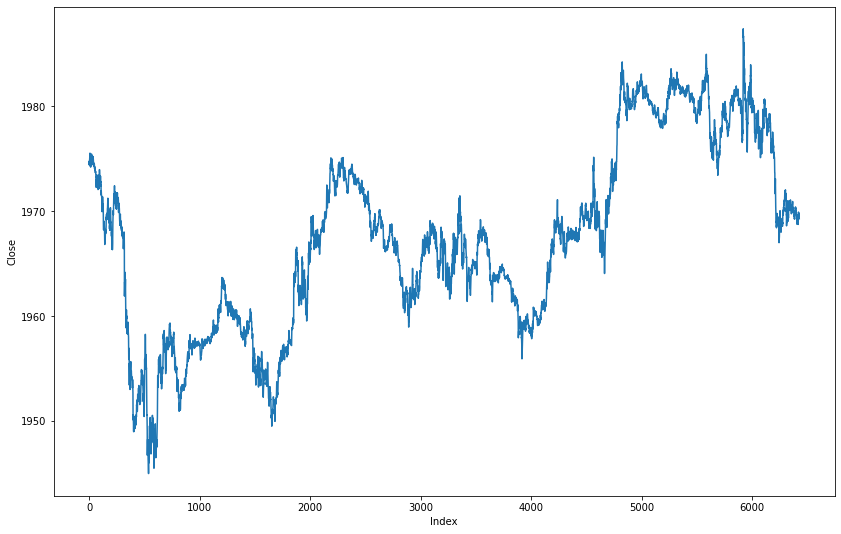

In [7]:
raw['Dates'] = pd.to_datetime(raw['Dates'])

data_set = raw.loc[(raw['Dates'] >= start_date) & (raw['Dates'] <= end_date)]

data_set.reset_index(drop=True, inplace=True)

vol = data_set.reset_index()['Close']

#plot vol
plt.figure(figsize=(14, 9))
plt.plot(vol)
plt.xlabel('Index')
plt.ylabel('Close')
plt.show()

In [8]:
# min-max normalization
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
vol = scaler.fit_transform(np.array(vol).reshape(-1,1))

In [9]:
#distrribute train and test data
training_data_size = int(len(vol)*0.8)
test_data_size = len(vol)-training_data_size
train_data = vol[0:training_data_size,:]
test_data = vol[training_data_size:len(vol),:1]

#Converting an array of values into a dataset matrix.
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]    
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

X_train, y_train = create_dataset(train_data, time_step) ###i=0, 0,1,2,3-----49         50
X_test, y_test = create_dataset(test_data, time_step)

#Reshaping for LSTM Model input to be [samples, time steps, features].
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from keras.layers import Dropout



model_vol = Sequential()
model_vol.add(LSTM(time_step,return_sequences=True,input_shape=(time_step,1)))
model_vol.add(Dropout(lossrate))
model_vol.add(LSTM(time_step,return_sequences=True))
model_vol.add(Dropout(lossrate))
model_vol.add(LSTM(time_step))
model_vol.add(Dropout(lossrate))
model_vol.add(Dense(1))
model_vol.compile(loss='mean_squared_error',optimizer='adam')
#fit model
model_vol.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=epoch,batch_size=batchsize,verbose=1)

In [4]:
# model_vol.save("C:/Users/35003/OneDrive/Desktop/23spring/forecasting/project/gold_model_price.h5")
model_vol = load_model("gold_model_price.h5")

model_vol.summary()

2023-04-24 01:20:14.119634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 01:20:14.122434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 01:20:14.124032: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 50, 50)            10400     
                                                                 
 dropout_3 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_4 (LSTM)               (None, 50, 50)            20200     
                                                                 
 dropout_4 (Dropout)         (None, 50, 50)            0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

2023-04-24 01:20:14.658713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-04-24 01:20:14.660367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-04-24 01:20:14.662196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [14]:
train_predict = model_vol.predict(X_train)
test_predict = model_vol.predict(X_test)

train_predict_stat = pd.Series(model_vol.predict(X_train).squeeze())
test_predict_stat = pd.Series(model_vol.predict(X_test).squeeze())
y_train_stat=pd.Series(y_train)
y_test_stat=pd.Series(y_test)

39/39 [==============================] - 1s 20ms/step


In [12]:
def loglize(trans):
    # Convert the NumPy array to a pandas Series
    trans = trans.diff()


    # Check for NaN or infinite values and replace them with 0
    trans.fillna(0, inplace=True)

    # Add a 0 at the beginning of the Series
    trans = pd.concat([pd.Series([0]), trans], ignore_index=True)

    # Convert the Series to a 2D NumPy array
    trans = np.array(trans.values).reshape(-1, 1)

    # Replace any remaining NaN or infinite values with 0
    trans = np.where(np.isnan(trans) | np.isinf(trans), 0, trans)
    # 绘制 ACF 图
    plt.figure(figsize=(12, 4))
    plot_acf(trans, lags=10)
    plt.xlabel("Lags")
    plt.ylabel("ACF")
    plt.title("Autocorrelation Function")
    plt.show()

    # 绘制 PACF 图
    plt.figure(figsize=(12, 4))
    plot_pacf(trans, lags=10)
    plt.xlabel("Lags")
    plt.ylabel("PACF")
    plt.title("Partial Autocorrelation Function")
    plt.show()

    #  adf
    adf_result = adfuller(trans)

    # Print the test results
    print(f"ADF Statistic (differenced data): {adf_result[0]}")
    print(f"p-value (differenced data): {adf_result[1]}")

    # Check if the differenced time series is stationary
    if adf_result[1] < 0.05:
        print("The differenced time series is stationary.")
    else:
        print("The differenced time series is still not stationary.")

    return trans
    

<Figure size 864x288 with 0 Axes>

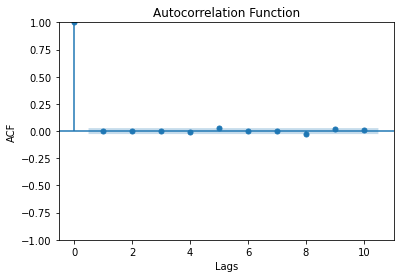

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x288 with 0 Axes>

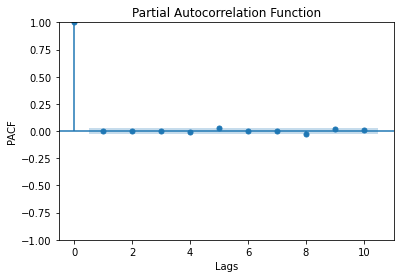

ADF Statistic (differenced data): -71.29240063484613
p-value (differenced data): 0.0
The differenced time series is stationary.


In [15]:
# Apply the loglize transformation
train_predict_stat = loglize(trans=train_predict_stat)

<Figure size 864x288 with 0 Axes>

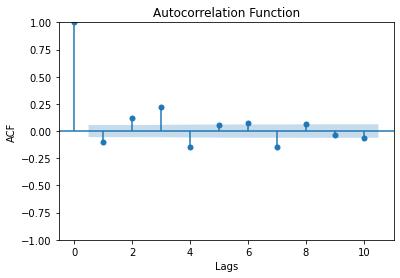

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x288 with 0 Axes>

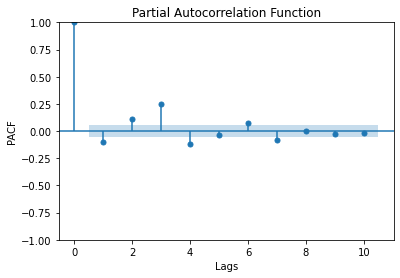

ADF Statistic (differenced data): -12.901187120407995
p-value (differenced data): 4.2447891145484716e-24
The differenced time series is stationary.


In [16]:
test_predict_stat = loglize(trans=test_predict_stat)

<Figure size 864x288 with 0 Axes>

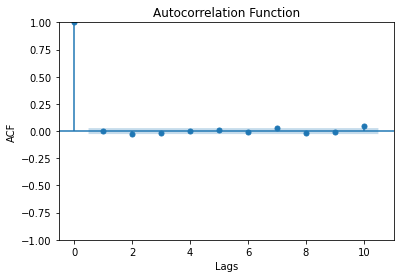

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x288 with 0 Axes>

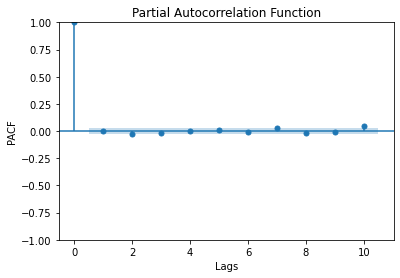

ADF Statistic (differenced data): -21.473795435067352
p-value (differenced data): 0.0
The differenced time series is stationary.


In [17]:
y_train_stat = loglize(trans=y_train_stat)

<Figure size 864x288 with 0 Axes>

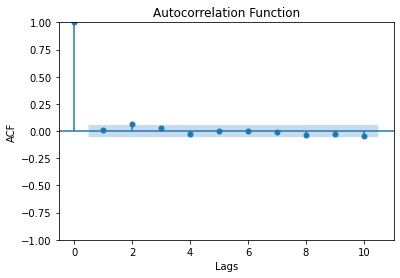

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x288 with 0 Axes>

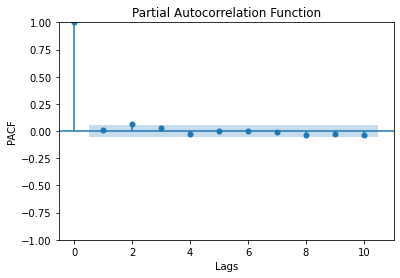

ADF Statistic (differenced data): -23.10624636877301
p-value (differenced data): 0.0
The differenced time series is stationary.


In [18]:
y_test_stat = loglize(trans=y_test_stat)

In [19]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
print("训练集的 rmse:", math.sqrt(mean_squared_error(y_train_stat,train_predict_stat)))
print("测试集的 rmse:", math.sqrt(mean_squared_error(y_test_stat,test_predict_stat)))
# 计算训练集的 MAE
train_mae = mean_absolute_error(y_train_stat, train_predict_stat)
print("训练集的 MAE:", train_mae)

# 计算测试集的 MAE
test_mae = mean_absolute_error(y_test_stat, test_predict_stat)
print("测试集的 MAE:", test_mae)

训练集的 rmse: 0.01396959339093124
测试集的 rmse: 0.013991827367205346
训练集的 MAE: 0.010001911569734989
测试集的 MAE: 0.010067947140410854


In [20]:
from sklearn.metrics import r2_score
r2_train = r2_score(y_train_stat, train_predict_stat)
r2_test = r2_score(y_test_stat, test_predict_stat)
print('r2_train:',r2_train)
print('r2_test:',r2_test) 

r2_train: -0.861012293084529
r2_test: -0.7228094010140453


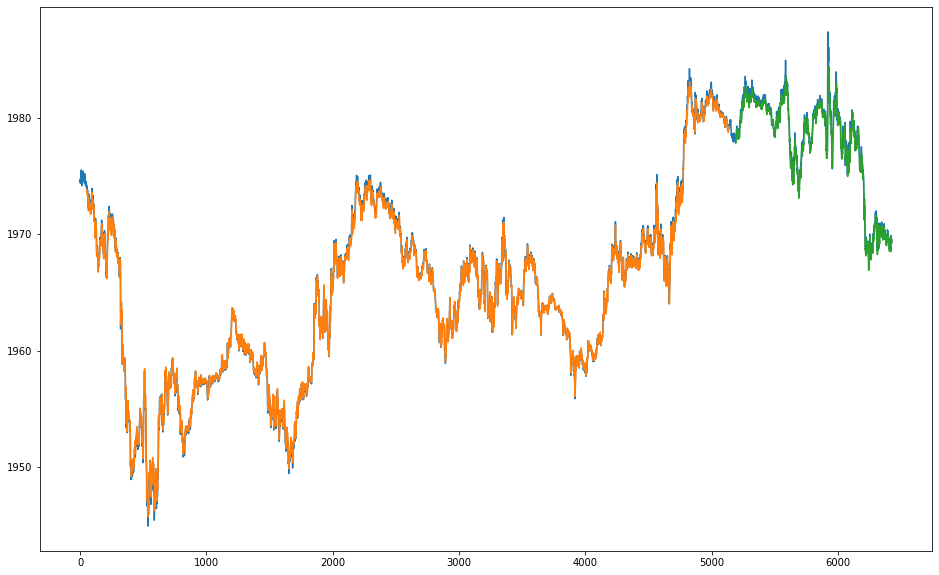

In [21]:
#anti-scale
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

look_back = time_step
trainPredictPlot = np.empty_like(vol)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict

testPredictPlot = np.empty_like(vol)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(vol)-1, :] = test_predict

plt.figure(figsize=(16,10))# 使用 plt.figure() 创建一个新的绘图窗口，并设置窗口的大小为 16x10 英寸。
plt.plot(scaler.inverse_transform(vol))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [22]:
len(test_data)

x_input=test_data[-time_step:].reshape(1,-1)#从某一天的第一分钟开始
x_input.shape#=n_steps+1
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

# 输出列表的前 5 个元素,检查以确保列表被正确创建并包含期望的数据。
temp_input[:5]

[0.5888731730315868,
 0.5787364450730763,
 0.5810938236680769,
 0.5766148043375736,
 0.57378595002357]

In [23]:
#predict next 10 day
from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<forcast_time):
    
    if(len(temp_input)>time_step):
        
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        
        yhat = model_vol.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model_vol.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output[:51])

[0.5680321]
51
1 day input [0.57873645 0.58109382 0.5766148  0.57378595 0.57449316 0.57190005
 0.57213579 0.57685054 0.57708628 0.58250825 0.58628006 0.59123055
 0.59075908 0.59099481 0.59948138 0.59476662 0.59688826 0.59547383
 0.58462989 0.58816596 0.59075908 0.58203678 0.5834512  0.58015087
 0.57850071 0.57142857 0.56671381 0.56482791 0.56058463 0.56247053
 0.56176332 0.56388496 0.57048562 0.5815653  0.57119283 0.56247053
 0.56223479 0.56954267 0.56011315 0.57260726 0.58203678 0.58793022
 0.58227251 0.58439415 0.58533711 0.57897218 0.58015087 0.57850071
 0.57307874 0.56803209]
1 day output [[0.56364554]]
2 day input [0.58109382 0.5766148  0.57378595 0.57449316 0.57190005 0.57213579
 0.57685054 0.57708628 0.58250825 0.58628006 0.59123055 0.59075908
 0.59099481 0.59948138 0.59476662 0.59688826 0.59547383 0.58462989
 0.58816596 0.59075908 0.58203678 0.5834512  0.58015087 0.57850071
 0.57142857 0.56671381 0.56482791 0.56058463 0.56247053 0.56176332
 0.56388496 0.57048562 0.5815653  0.57

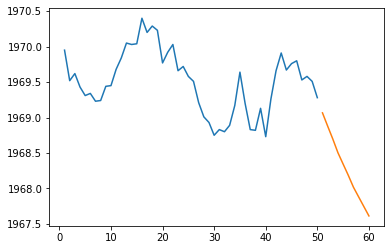

In [24]:
#Plotting the FINAL results


day_new = np.arange(1, time_step + 1)
day_pred = np.arange(time_step + 1, time_step+1+forcast_time)

plt.plot(day_new,scaler.inverse_transform(vol[len(vol) - time_step:])) # len(vol) - n_step
plt.plot(day_pred,scaler.inverse_transform(lst_output))
